In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# spacy, textblob and nltk for language processing
from textblob import TextBlob

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
sns.set_style('white')

In [2]:
data_path = Path('data', 'sentiment140')
if not data_path.exists():
    data_path.mkdir(parents=True)
names = ['polarity', 'id', 'date', 'query', 'user', 'text']

In [3]:
def load_train_data():
    parquet_file = data_path / 'train.parquet'
    if not parquet_file.exists():
        df = (pd.read_csv(data_path / 'train.csv', low_memory=False, encoding='latin1', header=None,
                          names=names, parse_dates=['date']).drop(['id', 'query'], axis=1)
              .drop_duplicates(subset=['polarity', 'text']))
        df = df[df.text.str.len() <= 140]
        df.polarity = (df.polarity > 0).astype(int)
        df.to_parquet(parquet_file)
        return df
    else:
        return pd.read_parquet(parquet_file)
train = load_train_data()
train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1566668 entries, 0 to 1599999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   polarity  1566668 non-null  int32         
 1   date      1566668 non-null  datetime64[ns]
 2   user      1566668 non-null  object        
 3   text      1566668 non-null  object        
dtypes: datetime64[ns](1), int32(1), object(2)
memory usage: 53.8+ MB


In [4]:
train.sample(10)

polarity                date             user  \
974304          1 2009-05-17 23:04:26  jamieharrington   
1273509         1 2009-06-01 23:08:22           skyn3t   
826504          1 2009-04-18 23:52:44     rhymen0cer0s   
453788          0 2009-06-07 17:39:55    liveinlove852   
47544           0 2009-05-02 03:17:00        Tougelabs   
89542           0 2009-05-10 08:58:06      BrendaRanae   
881095          1 2009-05-03 01:51:34      screwbarney   
892420          1 2009-05-03 17:19:14          ryanr09   
1208806         1 2009-05-31 23:35:43       kristinths   
956933          1 2009-05-17 05:21:43  peace_luv_hope2   

                                                      text  
974304   @TyPie you don't still have the other one do y...  
1273509  @mirkwood come my house, i will gift you some,...  
826504   Not many people, but we did get encored. It wa...  
453788   just talked to selena gomez on the phone ...th...  
47544    Driving back to ny from oxford ct, trying to u...  
89542    @dannywood Happy Mom's Day to your mom...I los...  
881095                             is back from Tagaytay!   
892420   @LeonardoZ haha...I'll pay off that house. *lo...  
1208806                                Had a good weekend   
956933   @mileycyrus good mornin miley.i luv u.ur such ...

In [5]:
def load_test_data():
    parquet_file = data_path / 'test.parquet'
    if not parquet_file.exists():
        df = (pd.read_csv('data/sentiment140/test.csv', low_memory=False, encoding='latin1', header=None,
                          names=names, parse_dates=['date']).drop(['id', 'query'], axis=1)
              .drop_duplicates(subset=['polarity', 'text']))
        df = df[(df.text.str.len() <= 140) & (df.polarity.isin([0, 4]))]
        df.to_parquet(parquet_file)
        return df
    else:
        return pd.read_parquet(parquet_file)
test = load_test_data()
test.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 0 to 497
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   polarity  354 non-null    int64              
 1   date      354 non-null    datetime64[ns, UTC]
 2   user      354 non-null    object             
 3   text      354 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(1), object(2)
memory usage: 13.8+ KB


In [6]:
test.sample(10)

polarity                      date           user  \
237         4 2009-05-11 03:17:54+00:00       jhall515   
123         0 2009-05-31 06:51:44+00:00     nicoleisms   
476         4 2009-06-13 16:24:08+00:00       tessalau   
489         4 2009-06-13 16:24:15+00:00  A_TALL_BLONDE   
410         0 2009-06-02 03:34:37+00:00     arianaflyy   
7           4 2009-05-11 03:26:10+00:00      dcostalis   
40          4 2009-05-17 15:05:03+00:00    VickyTigger   
15          4 2009-05-11 05:20:15+00:00   cameronwylie   
454         4 2009-06-08 00:01:27+00:00          aiban   
104         0 2009-05-25 17:46:06+00:00         fwhamm   

                                                  text  
237                         reading on my new Kindle2!  
123  VIRAL MARKETING FAIL. This Acia Pills brand ou...  
476  Excited about seeing Bobby Flay and Guy Fieri ...  
489  i lam so in love with Bobby Flay... he is my f...  
410                   this dentist's office is cold :/  
7                        Jquery is my new best friend.  
40   I'm listening to "P.Y.T" by Danny Gokey &lt;3 ...  
15   #lebron best athlete of our generation, if not...  
454  I'd say some sports writers are idiots for say...  
104  is Twitter's connections API broken? Some twee...

In [7]:
train.head()

polarity                date             user  \
0         0 2009-04-06 22:19:45  _TheSpecialOne_   
1         0 2009-04-06 22:19:49    scotthamilton   
2         0 2009-04-06 22:19:53         mattycus   
3         0 2009-04-06 22:19:57          ElleCTF   
4         0 2009-04-06 22:19:57           Karoli   

                                                text  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....

In [8]:
train.polarity = (train.polarity>0).astype(int)
train.polarity.value_counts()

1    784335
0    782333
Name: polarity, dtype: int64

In [9]:
test.polarity = (test.polarity>0).astype(int)
test.polarity.value_counts()

1    180
0    174
Name: polarity, dtype: int64

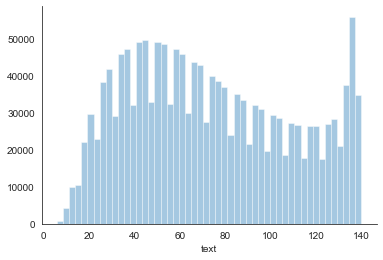

In [10]:
sns.distplot(train.text.str.len(), kde=False)
sns.despine();

In [11]:
train.date.describe()

count                 1566668
unique                 765666
top       2009-06-15 12:53:14
freq                       20
first     2009-04-06 22:19:45
last      2009-06-25 10:28:31
Name: date, dtype: object

In [12]:
train.user.nunique()

650606

In [13]:
train.user.value_counts().head(10)

lost_dog           549
webwoke            341
SallytheShizzle    276
VioletsCRUK        275
mcraddictal        274
tsarnick           247
what_bugs_u        246
Karen230683        237
DarkPiano          232
SongoftheOss       226
Name: user, dtype: int64

In [14]:
train.sample(10)

polarity                date             user  \
239667          0 2009-05-31 07:22:25  LaurenStevie_Ox   
202166          0 2009-05-30 08:28:58       kareninaaa   
779909          0 2009-06-24 23:47:10           iammic   
716028          0 2009-06-20 17:49:51  cardhousedreams   
914712          1 2009-05-09 23:31:48   AlissaFisher79   
374877          0 2009-06-05 21:41:37        sweets_89   
507318          0 2009-06-15 22:44:10          JooWang   
436703          0 2009-06-07 09:11:51          Chelysa   
783011          0 2009-06-25 01:32:35        vivienlow   
1167690         1 2009-05-31 05:35:40    Courtney_Meow   

                                                      text  
239667   In The Garden Tanning, ListeningTo Music And H...  
202166   @alqs duh me too qaaa. I dont have any idea ak...  
779909   No more Shaq-i-boo for PHX SUNS!  http://bit.l...  
716028   yummy sushi place with the best. bummed to be ...  
914712   @CaseLynn Not us as far as I know  hee hee. We...  
374877                   I have no one to eat dinner with   
507318   Ugh I forgot to get water. Hopefully I don't f...  
436703                    I want too ROCK AM RING now!!!!   
783011   I've lost interest in Twitter already.  How? LOL.  
1167690  im off,..gah exams tomorrow :| night twitter,....

In [15]:
# Create text vectorizer
vectorizer = CountVectorizer(min_df=.001, max_df=.8, stop_words='english')
train_dtm = vectorizer.fit_transform(train.text)
train_dtm

<1566668x934 sparse matrix of type '<class 'numpy.int64'>'
	with 6332930 stored elements in Compressed Sparse Row format>

In [16]:
test_dtm = vectorizer.transform(test.text)

In [17]:
# Train Naive Bayes Classifier
nb = MultinomialNB()
nb.fit(train_dtm, train.polarity)

MultinomialNB()

In [18]:
predicted_polarity = nb.predict(test_dtm)
accuracy_score(test.polarity, predicted_polarity)

0.7768361581920904

In [19]:
# TextBlob for Sentiment Analysis
sample_positive = train.text.loc[25632]
print(sample_positive)
parsed_positive = TextBlob(sample_positive)
parsed_positive.polarity

good morning!! in about two hours im going to study  and ill will mis greys anatomy a lot im a hug fan!!! xoxo


0.01171875

In [20]:
sample_negative = train.text.loc[636079]
print(sample_negative)
parsed_negative = TextBlob(sample_negative)
parsed_negative.polarity

 i hate this place


-0.8

In [21]:
def estimate_polarity(text):
    return TextBlob(text).sentiment.polarity

train[['text']].sample(10).assign(sentiment=lambda x: x.text.apply(estimate_polarity)).sort_values('sentiment')

text  sentiment
623331   @gatormikenews There was a comment on my blog ...     0.0000
1363023  PLEASE BELIEVE ANYTHING YU DO I CAN DO BETTA.....     0.0000
975347   @Kay_Nain  i just wake madam..but i gone back....     0.0000
163671   @bronte_saurus Oh. Hrmmm in that case I have n...     0.0000
811944     Sitting in my cube watching the squirrels play      0.0000
1581488  http://twitpic.com/7j6gb - I'll be seeing the ...     0.2000
876382   @LuvinMeSomeD I love it! Early afternoon wine ...     0.4375
1364878  @shaundiviney what if i want more calls but my...     0.5000
806753   @ElleSergi haha! That made me laugh. I'd certa...     0.5875
860993   @Raznwlvs Thank you for posting pics of the wo...     0.7500

In [22]:
# Compare with TextBlob Polarity Score
test['sentiment'] = test.text.apply(estimate_polarity)
accuracy_score(test.polarity, (test.sentiment>0).astype(int))

0.7429378531073446

In [23]:
roc_auc_score(y_true=test.polarity, y_score=test.sentiment)

0.8254948914431672

In [24]:
roc_auc_score(y_true=test.polarity, y_score=nb.predict_proba(test_dtm)[:, 1])

0.848595146871009

In [25]:
fpr_tb, tpr_tb, _ = roc_curve(y_true=test.polarity, y_score=test.sentiment)
roc_tb = pd.Series(tpr_tb, index=fpr_tb)
fpr_nb, tpr_nb, _ = roc_curve(y_true=test.polarity, y_score=nb.predict_proba(test_dtm)[:, 1])
roc_nb = pd.Series(tpr_nb, index=fpr_nb)

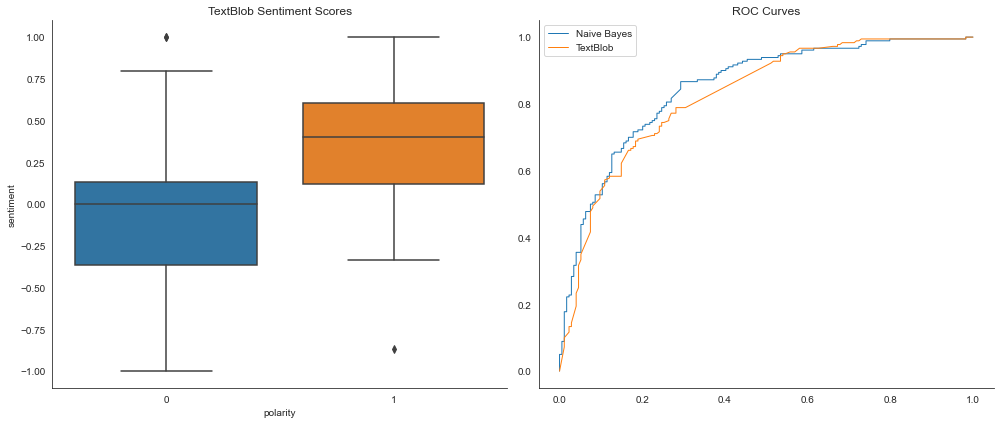

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.boxplot(x='polarity', y='sentiment', data=test, ax=axes[0])
axes[0].set_title('TextBlob Sentiment Scores')
roc_nb.plot(ax=axes[1], label='Naive Bayes', legend=True, lw=1, title='ROC Curves')
roc_tb.plot(ax=axes[1], label='TextBlob', legend=True, lw=1)
sns.despine()
fig.tight_layout();
# Naive Bayes outperforms TextBlob in this case. chk below